In [50]:
import pandas as pd
import json
import re
from IPython.display import display

data_dir = "../data/"
spotify_dir = data_dir + "spotify/cleaned/"

# These are numeric attributes which we can normalize
music_atts = ["track.duration_ms", "track.explicit", "danceability",
              "energy", "key", "loudness", "speechiness", "acousticness",
              "instrumentalness", "liveness", "valence", "tempo"]


playlist_metadata = pd.read_csv (spotify_dir + '112022_df_playlist_metadata.csv').iloc[:, 1:]
playlist_tracks = pd.read_csv (spotify_dir + '112022_df_playlist_tracks_metadata.csv').iloc[:, 1:]
track_metadata = pd.read_csv (spotify_dir + '112022_df_tracks_metadata.csv').iloc[:, 1:]

# Normalise numeric attributes
track_metadata[music_atts] = (track_metadata[music_atts]-track_metadata[music_atts].mean())/track_metadata[music_atts].std()

# De-JSON the artists (removing extra info)
artists_by_song = track_metadata["track.artists"]
for song_idx, string in enumerate(artists_by_song):
    p1 = re.compile(r'\'(?!(\w )|( \w))')
    p2 = re.compile(r' \'(\w)')
    string = p1.sub('\"', string)
    string = p2.sub(' \"\\1', string)

    json_artists = json.loads(string)
    list_arists_names = "["
    for artist_idx in range(len(json_artists)):
        name = json_artists[artist_idx]["name"]
        list_arists_names += "'" + name + "',"
    list_arists_names = list_arists_names[:-1]+"]"
    track_metadata.iloc[song_idx, 5] = list_arists_names

    

# Define function to get data of songs for a country
def get_by_playlist_name(country):
    cols_to_use = playlist_tracks.columns.difference(track_metadata.columns)
    cols_to_use = cols_to_use.insert(1, "track.id")
    
    # Pick non overalpping tacks
    playlist_tracks_m = playlist_tracks[cols_to_use].loc[playlist_tracks['playlist.name'] == country]
    
    playlist_full = pd.merge(
        playlist_tracks_m,
        track_metadata,
        how="inner",
        on="track.id",
    )

    all_country_tracks = playlist_full
    all_country_tracks = all_country_tracks.drop(['playlist.name', 'playlist.id'], axis=1)
    
    unique_arr = all_country_tracks["track.id"].unique()
    country_tracks = all_country_tracks.drop_duplicates(subset = "track.id")
    country_tracks.insert(2, "times_added", None)

    for i in unique_arr:
        times_added = len(all_country_tracks.loc[all_country_tracks["track.id"] == i].index)
        country_tracks.loc[all_country_tracks["track.id"] == i, "times_added"] = times_added

    return country_tracks
        

In [80]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def musical_sim_countries(a,b):
    # Read music data from dataframe, 
    # Describe to get mean and std
    # Keep only mean and std
    df1 = a[music_atts].describe().iloc[1:3,:]
    df2 = b[music_atts].describe().iloc[1:3,:]
    # Calculate the cosine similarity between the rows of the dataframes
    similarity = cosine_similarity(df1, df2)
    # The resulting array will have a shape of (n_samples_1, n_samples_2), 
    # where n_samples_1 is the number of rows in df1 and n_samples_2 is the number of rows in df2.
    # Each element in the array will be a similarity score between the corresponding rows in df1 and df2.
    [mean_sim, _],[_, std_sim] = similarity
    return mean_sim, std_sim, df2.iloc[0]

def musical_sim_entries (a,b):       
    display(a)
    display(b)
    # If the two songs are the same, then they are
    # musically identical
    if a["track.id"] == b["track.id"]:
        musical_sim = 1    
    else:
        musical_sim = cosine_similarity([a[music_atts]], [b[music_atts]])[0][0]
    return musical_sim

def meta_sim_entries(a,b):
    # Similarity indicators:
    # Artist
    # Album

        meta_dif = np.linalg.norm(a["times_added"] - b["times_added"])
        meta_sim = 1 - (dif/a["times_added"])

In [311]:
# initialize data of lists.
countries = []
mean_sims = []
std_sims = []
data = {}

sp = get_by_playlist_name("Top 50 - Spain")

for playlist_name in playlist_metadata["playlist.name"].unique():
    #if playlist_name != "Top 50 - Spain" and playlist_name != "Top 50 - Morocco":
    if playlist_name != "Top 50 - Spain":

        # Get country from playlist name
        exp = re.compile(r"Top 50( - ||\+ )(.+)")
        country = exp.search(playlist_name).group(2)
        country_data = get_by_playlist_name(playlist_name)
        mean_sim, std_sim, mean_chars = musical_sim_countries(sp,country_data)
        for char in music_atts:
            key = "mean."+char
            value = mean_chars.loc[char]

            if key not in data:
                data[key]=[value]
            else:
                data[key].append(value)
        mean_sims.append(mean_sim)
        std_sims.append(std_sim)
        countries.append(country)

# Creates pandas DataFrame.
data.update({"mean.musicalsim2spain": mean_sims})

music_sim_df = pd.DataFrame(data, index=countries)
display(music_sim_df)

,mean.track.duration_ms,mean.track.explicit,mean.danceability,mean.energy,mean.key,mean.loudness,mean.speechiness,mean.acousticness,mean.instrumentalness,mean.liveness,mean.valence,mean.tempo,mean.musicalsim2spain
Argentina,-0.126464,1.065310e-01,0.498974,0.141811,-0.168553,0.454863,0.107099,-0.294782,-0.143051,-0.083789,0.048991,-0.292810,0.863485
Australia,0.121359,1.860470e-01,-0.328382,-0.348473,-0.085702,-0.178443,0.008992,-0.021807,-0.050652,0.055406,-0.386298,0.128355,-0.654669
Austria,-0.235747,5.160428e-02,-0.105610,-0.026073,-0.068669,-0.061476,-0.100272,-0.134660,-0.093759,0.199159,0.098436,0.145142,-0.097335
Belgium,-0.081920,1.747588e-01,-0.027318,-0.023923,0.167068,0.048163,0.202919,-0.182273,-0.141152,0.029511,-0.107283,0.128007,0.117438
Bolivia,-0.072411,6.291264e-17,0.479422,0.309031,-0.222710,0.772752,-0.183933,-0.389416,-0.117144,0.026366,0.055247,-0.225874,0.908686
Brazil,-0.215964,-1.413957e-01,-0.047695,0.623034,0.011157,0.813725,0.001724,0.382918,-0.050560,1.455776,0.511415,0.243688,0.389299
Canada,0.041444,6.059817e-02,-0.357014,-0.409004,0.103431,-0.420370,-0.131294,0.138897,-0.092334,0.106839,-0.209725,0.180619,-0.848262
Chile,0.133659,3.676289e-01,0.790126,0.493939,-0.107633,0.628577,-0.045367,-0.374202,-0.088349,-0.059664,0.337642,-0.519385,0.860642
Colombia,0.104234,2.326765e-01,0.663331,0.432996,0.043720,0.718706,0.204891,-0.198789,-0.119902,-0.011491,0.283002,-0.048899,0.896198
Costa Rica,0.033331,2.209308e-01,0.377496,0.222912,-0.218650,0.556189,0.089560,-0.199356,-0.150683,0.051715,0.045200,-0.022637,0.875635


In [312]:
from pathlib import Path
import dataframe_image as dfi

# Load spanish migration data and language data
migration_dir = data_dir + "spain/migration/"
language_dir = data_dir + "spain/language/cleaned/"

mig_spain = pd.read_csv (migration_dir + '01006bsc.csv')
lang_spain = pd.read_csv (language_dir + 'Spanish_language_4.csv')

# Rename columns
mig_spain = mig_spain.rename(columns={"Country of Origin": "country",
                              "Total": "total.migration2spain"})
lang_spain = lang_spain.rename(columns={"Country": "country",
                                "Population": "total.population",
                                "Percentage of Spanish speakers (including limited competence speakers)": "percentage.spanishSpkrs"})

# Convert percentage to float
lang_spain["percentage.spanishSpkrs"] = lang_spain["percentage.spanishSpkrs"].apply(lambda x: float(x)/100)

# Normalize columns
mig_spain["total.migration2spain"] = (mig_spain["total.migration2spain"]-mig_spain["total.migration2spain"].mean())/mig_spain["total.migration2spain"].std()
lang_spain["percentage.spanishSpkrs"] = (lang_spain["percentage.spanishSpkrs"]-lang_spain["percentage.spanishSpkrs"].mean())/lang_spain["percentage.spanishSpkrs"].std()
lang_spain["total.population"] = (lang_spain["total.population"]-lang_spain["total.population"].mean())/lang_spain["total.population"].std()

# Merge migration with music simularity to spain
migration_music_sim = pd.merge(
    mig_spain,
    music_sim_df,
    how="inner",
    left_on="country",
    right_index=True
)

# Merge previous data with spanish language data
migration_music_sim = pd.merge(
    migration_music_sim,
    lang_spain,
    how="inner",
    on="country"
)


display(migration_music_sim)
#dfi.export(migration_music_sim, 'migration_music_sim.png')

filepath = Path(data_dir + "experiments/migration_music_sim.csv")  

filepath.parent.mkdir(parents=True, exist_ok=True)  

migration_music_sim.to_csv(filepath, index=False)  

,country,total.migration2spain,mean.track.duration_ms,mean.track.explicit,mean.danceability,mean.energy,mean.key,mean.loudness,mean.speechiness,mean.acousticness,mean.instrumentalness,mean.liveness,mean.valence,mean.tempo,mean.musicalsim2spain,total.population,percentage.spanishSpkrs
0,Germany,0.748392,-0.294000,2.019939e-01,-0.047689,-0.006323,-0.105379,-0.021009,0.162974,-0.179195,-0.096342,0.088513,0.053745,0.239069,0.052012,-0.082150,-0.672210
1,Austria,-0.430038,-0.235747,5.160428e-02,-0.105610,-0.026073,-0.068669,-0.061476,-0.100272,-0.134660,-0.093759,0.199159,0.098436,0.145142,-0.097335,-0.167964,-0.672210
2,Belgium,-0.125465,-0.081920,1.747588e-01,-0.027318,-0.023923,0.167068,0.048163,0.202919,-0.182273,-0.141152,0.029511,-0.107283,0.128007,0.117438,-0.164859,-0.648100
3,Denmark,-0.414804,0.000040,5.581411e-02,-0.162756,-0.072331,-0.128441,-0.036668,-0.179867,-0.242771,-0.171200,0.044751,0.097562,0.133555,-0.176315,-0.171078,-0.672210
4,Estonia,-0.462221,-0.080415,1.939499e-01,-0.350033,-0.176391,-0.005400,-0.242109,-0.035931,-0.120439,0.149581,0.173366,-0.489054,0.223119,-0.577067,-0.175831,-0.744541
5,Finland,-0.396455,-0.119209,-4.668727e-02,0.072207,0.153195,-0.095586,0.207222,-0.145499,-0.406836,-0.075046,0.056606,0.143524,0.084433,0.546735,-0.171352,-0.696320
6,France,1.090758,-0.245229,6.745485e-01,0.076398,0.030461,0.264129,0.058926,0.461620,0.094667,-0.093846,-0.199854,-0.017618,0.153449,0.212950,-0.100213,-0.431107
7,Hungary,-0.406080,-0.385236,4.158698e-01,0.107091,-0.058732,-0.010352,-0.126307,0.122152,-0.124467,-0.162271,-0.028365,-0.097023,0.097057,0.110174,-0.165959,-0.744541
8,Ireland,-0.367006,0.107682,-6.147641e-02,-0.386857,-0.211418,-0.159765,-0.235715,-0.204179,0.011640,-0.047440,0.113286,-0.072841,0.223010,-0.775024,-0.172112,-0.672210
9,Italy,0.579880,-0.235675,5.174792e-01,-0.157882,0.384247,0.032167,0.433036,0.344735,-0.369834,-0.165954,0.092995,-0.335068,0.027667,0.500536,-0.108069,-0.503438


,Attributes,Coefficients
0,mean.track.duration_ms,-0.311436
1,mean.track.explicit,-4.321761
2,mean.danceability,4.213655
3,mean.energy,4.499870
4,mean.key,-0.069229
5,mean.loudness,-1.705097
6,mean.speechiness,6.621505
7,mean.acousticness,-1.315734
8,mean.instrumentalness,-2.865513
9,mean.liveness,-0.322570


,Attributes,Coefficients
11,mean.tempo,2.694332
8,mean.instrumentalness,-2.865513
2,mean.danceability,4.213655
1,mean.track.explicit,-4.321761
3,mean.energy,4.499870
6,mean.speechiness,6.621505


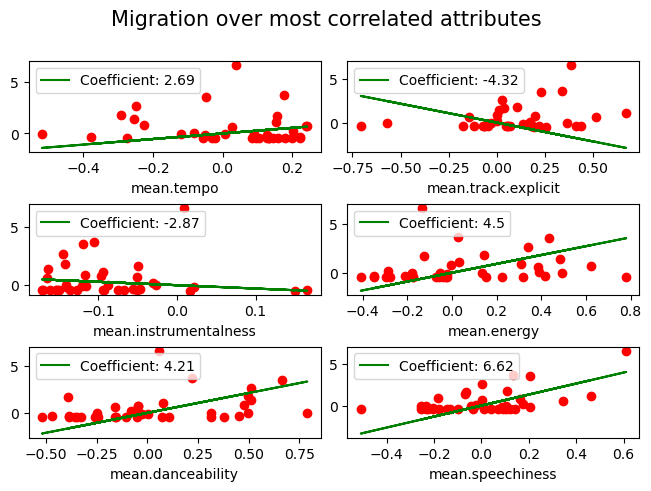

In [319]:
from sklearn import linear_model
import matplotlib.pyplot as plt

df = migration_music_sim

X = df.iloc[:,2:]
y = df['total.migration2spain']

regr = linear_model.LinearRegression()
regr.fit(X, y)

results = pd.DataFrame({"Attributes": X.columns,
                        "Coefficients": regr.coef_})

display(results)
best_coefficients = results[results["Attributes"] != "mean.musicalsim2spain"]

best_coefficients = best_coefficients.assign(f = abs(results['Coefficients'])).sort_values('f').drop('f', axis=1).iloc[-6:]
display(best_coefficients)

# Create figure and axes object
fig, axs = plt.subplots(3, 2, constrained_layout=True)
fig.suptitle("Migration over most correlated attributes\n", fontsize=15)
                  
i=0
j=0
for index, row in best_coefficients.iterrows():
    att_regr = linear_model.LinearRegression()
    attribute = row["Attributes"]
    coefficient = row["Coefficients"]
    vals = df.loc[:,attribute]
    axs[i, j].scatter(vals, y, color = "red")
    axs[i, j].plot(vals, coefficient*vals, color = "green", label = "Coefficient: "+ str(round(coefficient, 2)))
    #axs[i, j].title.set_text(attribute +" VS total.migration2spain")
    axs[i, j].set_xlabel(attribute)

    axs[i, j].legend(loc="upper left")
    
    if i==2:
        i=0
        j+=1
    else:
        i+=1  
        
plt.savefig('coefficients_with_morocco.png')
plt.show()

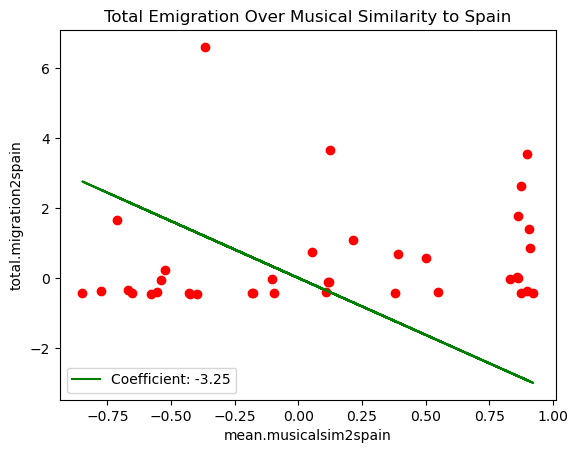

In [318]:
coefficient = results.loc[12,"Coefficients"]

vals = df.loc[:,"mean.musicalsim2spain"]
plt.scatter(vals, y, color = "red")
plt.plot(vals, coefficient*vals, color = "green", label = "Coefficient: "+ str(round(coefficient, 2)))
plt.title("Total Emigration Over Musical Similarity to Spain")
plt.xlabel("mean.musicalsim2spain")
plt.ylabel("total.migration2spain")
plt.legend(loc="lower left")

plt.savefig('sim_over_mig.png')
plt.show()
